<a href="https://colab.research.google.com/github/sen-28/Head-Circumference-Detection/blob/main/5_HC_U_Net_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

torch.cuda.empty_cache()
print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import helper
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import random
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import torchvision

In [ ]:
!cd /content
!pwd

/content


In [ ]:
!wget https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv?download=1 

--2022-01-28 16:38:56--  https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33688 (33K) [text/plain]
Saving to: ‘training_set_pixel_size_and_HC.csv?download=1’

training_set_pixel_ 100%[===================>]  32.90K  --.-KB/s    in 0s      

2022-01-28 16:38:57 (232 MB/s) - ‘training_set_pixel_size_and_HC.csv?download=1’ saved [33688/33688]



In [ ]:
!mv "/content/training_set_pixel_size_and_HC.csv?download=1" "/content/drive/MyDrive/HC_Dataset_5"

In [ ]:
!wget https://zenodo.org/record/1327317/files/training_set.zip?download=1

--2022-01-28 16:39:11--  https://zenodo.org/record/1327317/files/training_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132926838 (127M) [application/octet-stream]
Saving to: ‘training_set.zip?download=1’

training_set.zip?do 100%[===================>] 126.77M  18.5MB/s    in 9.4s    

2022-01-28 16:39:22 (13.5 MB/s) - ‘training_set.zip?download=1’ saved [132926838/132926838]



In [ ]:
!unzip /content/training_set.zip?download=1 -d "/content/drive/MyDrive/HC_Dataset_5" 

Archive:  /content/training_set.zip?download=1
   creating: /content/drive/MyDrive/HC_Dataset_5/training_set/
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/000_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/training_set/000_HC_Annotation.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/001_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/training_set/001_HC_Annotation.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/002_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/training_set/002_HC_Annotation.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/003_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/training_set/003_HC_Annotation.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/004_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/training_set/004_HC_Annotation.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/training_set/005_HC.png  
  inflatin

In [ ]:
os.rename('/content/drive/MyDrive/HC_Dataset_5/training_set_pixel_size_and_HC.csv?download=1', '/content/drive/MyDrive/HC_Dataset_5/training_set_pixel_size_and_HC.csv')

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/HC_Dataset_5/training_set_pixel_size_and_HC.csv')
filename = df['filename']
training_path = "/content/drive/MyDrive/HC_Dataset_5/training_set"

In [ ]:
df

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81
...,...,...,...
994,801_HC.png,0.296851,329.26
995,802_HC.png,0.212267,330.90
996,803_HC.png,0.202743,331.70
997,804_HC.png,0.281090,316.48


(540, 800, 3)


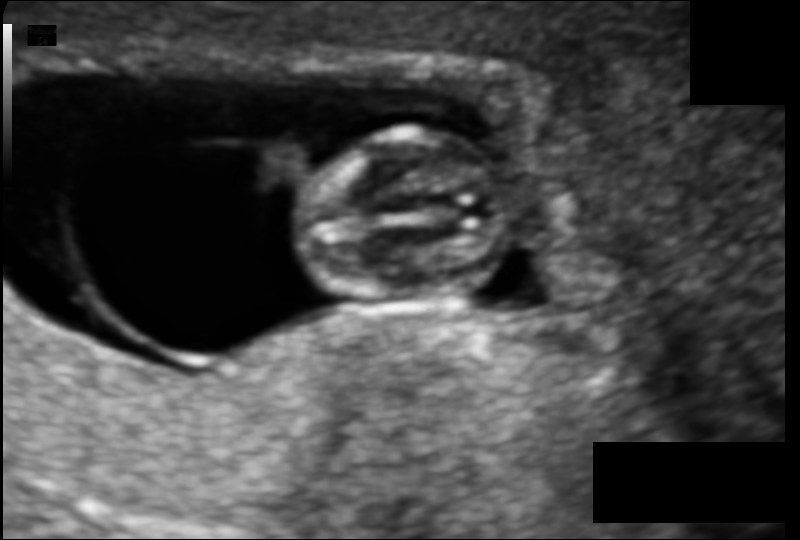

(540, 800, 3)


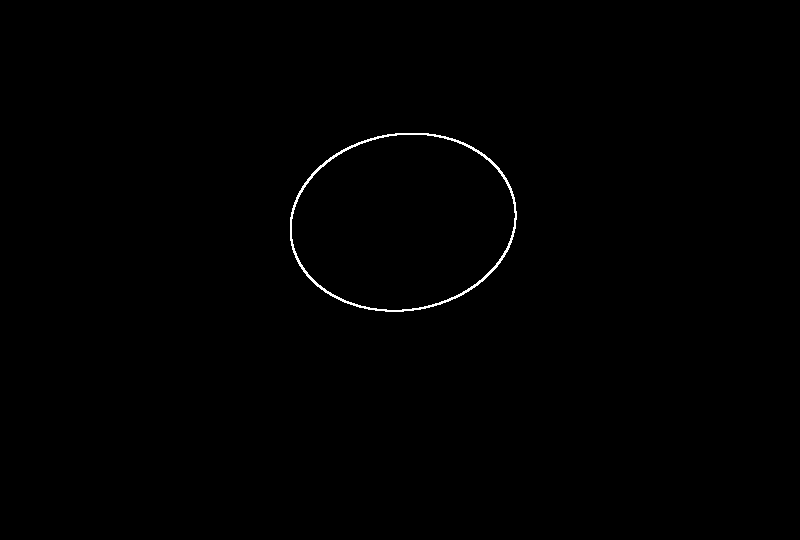

In [ ]:
image_path = training_path + '/' + filename[1]
image = cv2.imread(image_path)
print(image.shape)
cv2_imshow(image)
annotation_path = image_path.replace('.png', '_Annotation.png')
image = cv2.imread(annotation_path)
print(image.shape)
cv2_imshow(image)

In [ ]:
def make_mask(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, useless = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

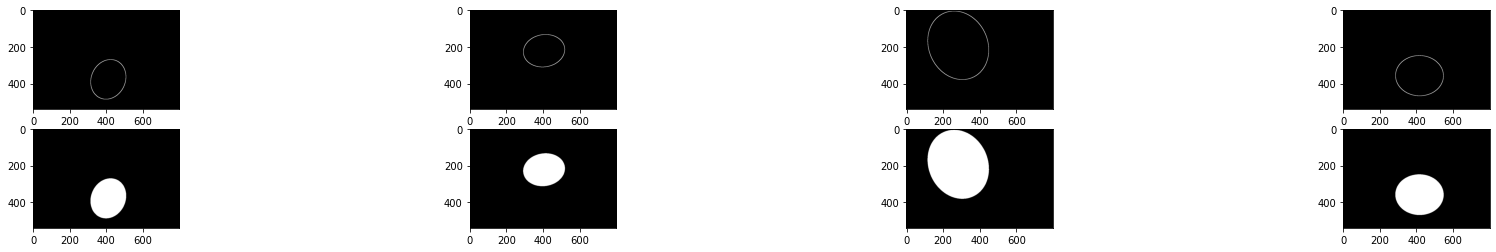

In [ ]:
fig = plt.figure(figsize = (30,4))
for index in range(4):
  file_path = os.path.join(training_path, filename[index].replace('.png','_Annotation.png'))

  ax = fig.add_subplot(2, 4, index+1)             
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 4, index+5)
  plt.imshow(make_mask(cv2.imread(file_path))) 

In [ ]:
# fig = plt.figure(figsize = (30,4))

for index in range(len(filename)):
  image_path = os.path.join(training_path, filename[index])
  mask_path = image_path.replace('.png','_Annotation.png')

  image = cv2.imread(image_path)
  # ax = fig.add_subplot(2, 4, index+1)             
  # plt.imshow(image)

  mask = cv2.imread(mask_path)
  # ax = fig.add_subplot(2, 4, index+2)
  # plt.imshow(mask)

  mask = make_mask(mask)
  # ax = fig.add_subplot(2, 4, index+3)
  # plt.imshow(mask)

  image_path = image_path.replace('training_set', 'new_training_set')
  mask_path = mask_path.replace('training_set', 'new_training_set')

  # print(image_path)
  # print(mask_path)

  cv2.imwrite(image_path, image)
  # ax = fig.add_subplot(2, 4, index+4)             
  # plt.imshow(cv2.imread(image_path))

  cv2.imwrite(mask_path, mask)
  # ax = fig.add_subplot(2, 4, index+5)             
  # plt.imshow(cv2.imread(mask_path))


In [ ]:
training_path = training_path.replace('training_set', 'new_training_set')

In [ ]:
# our dataset class
class HC_Dataset(Dataset):
  
  def __init__(self, training_path, df, train = True, transformX = None, transformY = None):
    self.training_path = training_path
    self.df = df
    self.train = train
    self.transformX = transformX
    self.transformY = transformY
    self.train_data, self.val_data = train_test_split(self.df, test_size = 0.20, random_state = 5)  
              
  def __len__(self):
    if self.train:
      length = len(self.train_data)
    else:
      length = len(self.val_data)
    return length
    
  def __getitem__(self, index):
      
    if self.train:
      image_path = os.path.join(self.training_path, self.train_data.iloc[index, 0])
      mask_path = image_path.replace('.png','_Annotation.png')
    else: 
      image_path = os.path.join(self.training_path, self.val_data.iloc[index, 0])
      mask_path = image_path.replace('.png','_Annotation.png')
        
    image = Image.open(image_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              image = TF.hflip(image)
              mask = TF.hflip(mask)

          # Random vertical flipping
          if random.random() > 0.5:
              image = TF.vflip(image)
              mask = TF.vflip(mask)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

    if self.transformX :
      image = self.transformX(image)
      mask = self.transformY(mask)
      
    return {'image': image, 'mask': mask}

In [ ]:
trans_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
trans_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor()
                              ])

In [ ]:
train_data = HC_Dataset(training_path, df, train = True, transformX = trans_X, transformY = trans_Y)
val_data = HC_Dataset(training_path, df, train = True, transformX = trans_X, transformY = trans_Y)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
val_loader = DataLoader(dataset = val_data, batch_size = 2, shuffle = True, num_workers = 2)

In [ ]:
def reverse_transformX(inp):
  image = inp.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

def reverse_transformY(inp):
  image = inp.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((1,1,1))
  image = image.clip(0, 1)
  return image

torch.Size([2, 1, 572, 572])
torch.Size([2, 1, 572, 572])


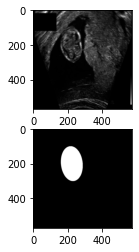

In [ ]:
for idx, item in enumerate(train_loader):
    fig = plt.figure()
    ax = fig.add_subplot(2, 2 , 2)
    print(item['image'].size())
    plt.imshow(reverse_transformX(item['image'][idx]))
    ax = fig.add_subplot(2, 2 , 4)
    print(item['mask'].size())
    plt.imshow(reverse_transformY(item['mask'][idx]))
    break

In [ ]:
class double_conv(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
       # x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        #x = self.dropout(x) #
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0037)

In [ ]:
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    
    return dice

In [ ]:
def dice_loss(y_predict, y_train): 
  dice_loss = 1 -(dice_index(y_predict, y_train))
  return dice_loss

In [ ]:
epochs = 30

train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['mask'].to('cuda')

    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(val_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['mask'].to('cuda')
                    
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(val_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()   

Epoch:  1 Batch:  0 Current Loss:  0.6573935747146606
Epoch:  1 Batch:  50 Current Loss:  0.3820957839488983
Epoch:  1 Batch:  100 Current Loss:  0.5493661761283875
Epoch:  1 Batch:  150 Current Loss:  0.3850536346435547
Epoch:  1 Batch:  200 Current Loss:  0.35336875915527344
Epoch:  1 Batch:  250 Current Loss:  0.3570091724395752
Epoch:  1 Batch:  300 Current Loss:  0.22000372409820557
Epoch:  1 Batch:  350 Current Loss:  0.38298630714416504
Epoch 1 completed
Average train loss is 0.3669643522799015: 
Average validation loss is 0.6236284454911947
Epoch:  2 Batch:  0 Current Loss:  0.2596869468688965
Epoch:  2 Batch:  50 Current Loss:  0.17435216903686523
Epoch:  2 Batch:  100 Current Loss:  0.34082019329071045
Epoch:  2 Batch:  150 Current Loss:  0.3342364728450775
Epoch:  2 Batch:  200 Current Loss:  0.35274016857147217
Epoch:  2 Batch:  250 Current Loss:  0.245950385928154
Epoch:  2 Batch:  300 Current Loss:  0.2465430498123169
Epoch:  2 Batch:  350 Current Loss:  0.337918072938919

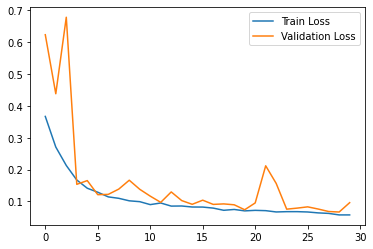

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HC_Dataset_5/model2.pth')

In [ ]:
model = UNet(1,1)
model.to('cuda')
print("Model Loaded to GPU")
model.load_state_dict(torch.load('/content/drive/MyDrive/HC_Dataset_5/model2.pth'))
model.eval()

Model Loaded to GPU


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [ ]:
X_train.size()

NameError: ignored

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))
print()
print(dice_index(out, y_train))
print(dice_loss(out, y_train))

tensor(0.9595, device='cuda:0')
tensor(0.0405, device='cuda:0')

tensor(0.9595, device='cuda:0')
tensor(0.0405, device='cuda:0')


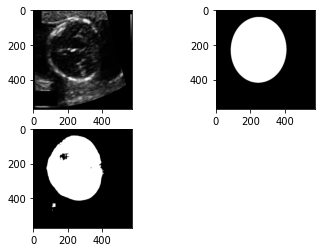

In [ ]:
fig = plt.figure()

axis = fig.add_subplot(2, 2, 1)
plt.imshow(reverse_transformX(X_train[0]))

axis = fig.add_subplot(2, 2, 2)
plt.imshow(reverse_transformY(y_train[0]))

axis = fig.add_subplot(2, 2, 3)
plt.imshow(reverse_transformY(out[0]))

In [ ]:
!cd /content
!pwd

/content


In [ ]:
!wget 'https://zenodo.org/record/1327317/files/test_set_pixel_size.csv?download=1'

--2022-01-29 05:31:11--  https://zenodo.org/record/1327317/files/test_set_pixel_size.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9096 (8.9K) [text/plain]
Saving to: ‘test_set_pixel_size.csv?download=1’

test_set_pixel_size 100%[===================>]   8.88K  --.-KB/s    in 0s      

2022-01-29 05:31:13 (214 MB/s) - ‘test_set_pixel_size.csv?download=1’ saved [9096/9096]



In [ ]:
!mv "/content/test_set_pixel_size.csv?download=1" "/content/drive/MyDrive/HC_Dataset_5"

In [ ]:
!wget 'https://zenodo.org/record/1327317/files/test_set.zip?download=1'

--2022-01-29 05:27:27--  https://zenodo.org/record/1327317/files/test_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43518463 (42M) [application/octet-stream]
Saving to: ‘test_set.zip?download=1’

test_set.zip?downlo 100%[===================>]  41.50M  13.4MB/s    in 3.1s    

2022-01-29 05:27:32 (13.4 MB/s) - ‘test_set.zip?download=1’ saved [43518463/43518463]



In [ ]:
!unzip /content/test_set.zip?download=1 -d "/content/drive/MyDrive/HC_Dataset_5"

Archive:  /content/test_set.zip?download=1
   creating: /content/drive/MyDrive/HC_Dataset_5/test_set/
  inflating: /content/drive/MyDrive/HC_Dataset_5/test_set/000_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/001_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/002_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/003_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/004_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/005_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/006_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/007_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/008_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset_5/test_set/009_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/010_HC.png  
 extracting: /content/drive/MyDrive/HC_Dataset_5/test_set/011_HC.png  
  inflating: /content/drive/MyDrive/HC_Dataset

In [ ]:
os.rename('/content/drive/MyDrive/HC_Dataset_5/test_set_pixel_size.csv?download=1', '/content/drive/MyDrive/HC_Dataset_5/test_set_pixel_size.csv')

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/HC_Dataset_5/test_set_pixel_size.csv')
filename = df['filename']
test_path = "/content/drive/MyDrive/HC_Dataset_5/test_set"

In [ ]:
df

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203
...,...,...
330,330_HC.png,0.138479
331,331_HC.png,0.075739
332,332_HC.png,0.113107
333,333_HC.png,0.219140


In [ ]:
class HC_test(Dataset):
    def __init__(self, test_path, df, transformX = None):
        self.test_path = test_path
        self.df = df
        self.transformX = transformX
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = test_path + '/' + image_name
        image = Image.open(image_path)
        
        if self.transformX :
            image = self.transformX(image)
        
        return {'image': image, 'image_name': image_name}

In [ ]:
test_data = HC_test(test_path, df, transformX = trans_X)

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

0 torch.Size([2, 1, 572, 572])


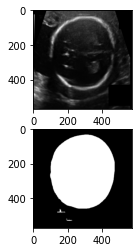

In [ ]:
for idx, item in enumerate(test_loader):
  
    X_test = item['image'].to('cuda')
    print(idx, X_test.size())
    y_test = (model(X_test) + 0.5).int().float()  
    
    fig = plt.figure()

    axis = fig.add_subplot(2, 2, 1)  
    plt.imshow(reverse_transformX(X_test[idx]))
        
    axis  = fig.add_subplot(2, 2, 3)
    plt.imshow(reverse_transformY(y_test[idx]))

    break

In [ ]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['mask'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
               
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(val_loader) 

0.9245927929878235

In [ ]:
avg_dice_index(train_loader)  

0.926738440990448

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) 

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      for idx , item in enumerate(test_loader):
        X_test = item['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
        file_names = item['image_name']
        image = transform(y_pred[0])
        torchvision.utils.save_image(image , os.path.join('/content/drive/MyDrive/HC_Dataset_5/test_masks', file_names[0]))
      print("Masks written")

Masks written


In [ ]:
def make_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [ ]:
df_pixel_size = pd.read_csv('/content/drive/MyDrive/HC_Dataset_5/test_set_pixel_size.csv')
results = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}
file_names = sorted([file for _,_,files in os.walk('/content/drive/MyDrive/HC_Dataset_5/test_masks/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/drive/MyDrive/HC_Dataset_5/test_masks/'+file_name)
    ellipse = make_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation.png'
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    results['filename'].extend([file_name])
    results['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    results['center_x_mm'].extend([pixel_size*center_x])
    results['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    results['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    results['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    results['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(results)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("final_results5.csv", index=False)
print('.csv file generated')

.csv file generated
